In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline
plt.rcParams.update({'font.size': 20})

root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'

In [2]:
def print_mem():
    memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
    print('Current memory usage: {:.2f}GB'.format(memory_usage))
print_mem()

Current memory usage: 0.62GB


In [3]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

In [4]:
directory = os.path.join(root_directory,'fly_5','func_0')
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(brain_path)*1 # this *1 is currently important for some fucking reason
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))
print_mem()


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 8.13 ms
brain shape is x,y,z,t (77, 128, 49, 4731)
Current memory usage: 9.77GB


In [5]:
t0 = time.time()
one_slice = brain[:,:,8,:].reshape(-1, brain.shape[-1])
print(time.time()-t0)

0.6802816390991211


In [49]:
clustering_dir = os.path.join(directory, 'super_voxels')

t0 = time.time()
model_ward = AgglomerativeClustering(n_clusters=2000, memory=clustering_dir, linkage='ward')
model_ward = model_ward.fit(one_slice)
print(time.time()-t0)

t0 = time.time()
model_average = AgglomerativeClustering(n_clusters=2000, memory=clustering_dir, linkage='average')
model_average = model_average.fit(one_slice)
print(time.time()-t0)

1.4691131114959717
213.66841673851013


In [50]:
labels_ward = model_ward.labels_.reshape(77,128)
labels_average = model_average.labels_.reshape(77,128)

# Plot outlines of clusters

In [52]:
image = labels_ward

In [53]:
x = np.linspace(0,image.shape[1], image.shape[1]*5)
y = np.linspace(0,image.shape[0], image.shape[0]*5)
X, Y= np.meshgrid(x[:-1],y[:-1])

In [54]:
f = lambda x,y: image[int(y), int(x)]
g = np.vectorize(f)

In [ ]:
import matplotlib as mpl

In [151]:
from sklearn.feature_extraction.image import grid_to_graph
connectivity = grid_to_graph(77,128)

In [155]:
for n_clusters in [1000,500,100]:
    print('working on {} clusters'.format(n_clusters))
    model_ward = AgglomerativeClustering(n_clusters=n_clusters, memory=clustering_dir, linkage='ward')
    model_ward = model_ward.fit(one_slice)
    labels_ward = model_ward.labels_.reshape(77,128)

    
    model_average = AgglomerativeClustering(n_clusters=n_clusters,
                                            memory=clustering_dir,
                                            linkage='ward',
                                            connectivity=connectivity)
    model_average = model_average.fit(one_slice)
    labels_average = model_average.labels_.reshape(77,128)
    
    fig,ax = plt.subplots()
    plt.imshow(labels_average, cmap='hsv')
    for i in range(n_clusters):
        t0 = time.time()
        blob = np.zeros(labels_ward.shape)
        blob[np.where(labels_ward==i)] = 1
        image = blob
        Z = g(X[:-1],Y[:-1])
        #ax.contour(Z, [0.5], colors='xkcd:neon blue', linewidths=[1],alpha=1, extent=[0-0.5, x[:-1].max()-0.5,0-0.5, y[:-1].max()-0.5])
        ax.contour(Z, [0.5], colors='k', linewidths=[1],alpha=1, extent=[0-0.5, x[:-1].max()-0.5,0-0.5, y[:-1].max()-0.5])
        #print('cluster: {}, time: {}'.format(i,time.time()-t0))

    # for i in range(10):
    #     t0 = time.time()
    #     blob = np.zeros(labels_average.shape)
    #     blob[np.where(labels_average==i)] = 1
    #     image = blob
    #     Z = g(X[:-1],Y[:-1])
    #     ax.contour(Z[::-1], [0.5], colors='k', linewidths=[.2],alpha=1)
        #print('cluster: {}, time: {}'.format(i,time.time()-t0))

    plt.title('fly_5, slice_8, {} clusters, ward linkage, black with connectivity constraint'.format(n_clusters), fontsize=10)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, timestr)
    plt.savefig(fname,dpi=300,bbox_inches='tight')
    plt.clf()

working on 1000 clusters
working on 500 clusters
working on 100 clusters


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
Z = g(X[:-1],Y[:-1])

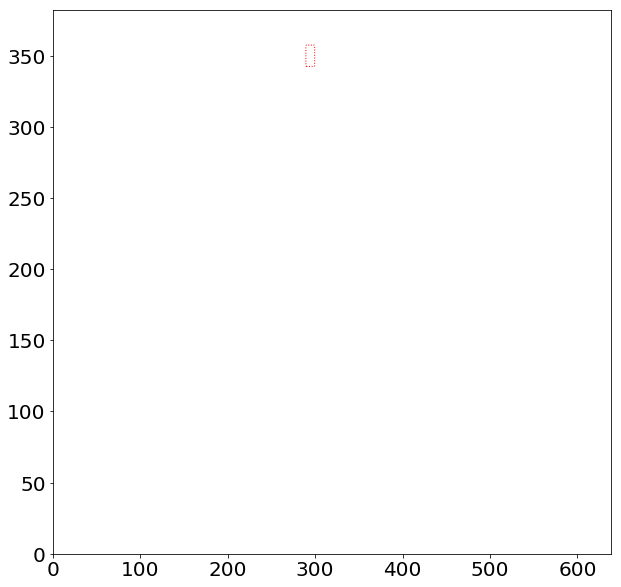

In [97]:
plt.figure(figsize=(10,10))
plt.contour(Z[::-1], [0.5], colors='r', linewidths=[1], linestyles='dotted')

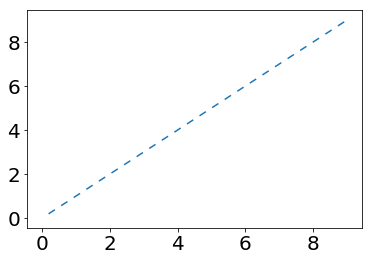

In [91]:
plt.plot(list(range(10)), linestyle=(5, (5, 5)))

In [233]:
k = []
for s in [2103, 1936, 2247, 2987]:
    np.random.seed(s)
    k.append(np.random.randint(0, 2, size=(2,6)))
arr = np.hstack([np.vstack(k)[:, :-1], np.vstack(k).T[::-1].T ])
image = np.zeros(shape=(arr.shape[0]+2, arr.shape[1]+2))
image[1:-1, 1:-1] = arr

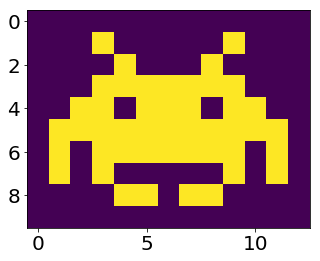

In [235]:
plt.imshow(image)

In [236]:
image

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [237]:
f = lambda x,y: image[int(y),int(x)]
g = np.vectorize(f)

In [228]:


x = np.linspace(0,image.shape[1], image.shape[1]*100)
y = np.linspace(0,image.shape[0], image.shape[0]*100)
X, Y= np.meshgrid(x[:-1],y[:-1])
Z = g(X[:-1],Y[:-1])

plt.imshow(image[::-1], origin="lower", interpolation="none", cmap="Blues")

plt.contour(Z[::-1], [0.5], colors='r', linewidths=[3], 
            extent=[0-0.5, x[:-1].max()-0.5,0-0.5, y[:-1].max()-0.5])

plt.show()

(998, 1299)